<a href="https://colab.research.google.com/github/nripstein/What-Bird-is-That/blob/main/Bird_Classification_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Obtain dataset from kaggle
# THIS WHOLE NOTEBOOK PROBABLY WILL TAKE 6 hours if I use b4

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download gpiosenka/100-bird-species
!unzip -q 100-bird-species.zip -d dataset

100% 1.95G/1.96G [01:06<00:00, 36.0MB/s]
100% 1.96G/1.96G [01:06<00:00, 31.7MB/s]


# Import dependencies

In [ ]:
import os
import pathlib
from glob import glob
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime as dt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from PIL import Image
import pandas as pd

In [ ]:
!pip install -U -q tensorflow==2.9.0  # tensorflow 2.10 and greater can't export efficientnet models properly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 37.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Define helper functions to be used later

In [ ]:
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred)
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=1) # zero division param new
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
    return model_results

In [ ]:
def pred_and_plot9(model, class_names, directory):
    random_images = random.sample(os.listdir(directory), 9)
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    for i, image_name in enumerate(random_images):
        image_path = os.path.join(directory, image_name)
        image_path = os.path.join(image_path, os.listdir(image_path)[0])

        if os.path.isfile(image_path):
            # Read the image, resize it to match the input size your model expects,
            # and normalize it in the same way as your training/test images
            img = Image.open(image_path)
            img = img.resize((224, 224))  # Resize the image
            img_array = np.array(img) / 255.  # Normalize the image
            img_array = img_array[:,:,:3] # ensure img is 224,224,3

            # Make a prediction
            pred = model.predict(np.expand_dims(img_array, axis=0))

            # Get the predicted class
            pred_class = class_names[np.argmax(pred[0])]

            # Plot the image and predicted class
            row = i // 3
            col = i % 3
            axes[row, col].imshow(img)
            axes[row, col].set_title(f"Pred: {pred_class}\nLabel: {image_name}")
            axes[row, col].axis(False)
        else:
            print(f"Skipping {image_path} as it is not a valid image file.")

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]


    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # print(len(total_acc))
    # print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Load data in appropriate format

In [ ]:
train_dir = "dataset/train"
valid_dir = "dataset/valid"
test_dir = "dataset/test"
IMAGE_DIMENSIONS = (380, 380) # efficientnetB4 image size

data_gen = ImageDataGenerator()  # don't use rescale=1./255 because EfficientNetBx doesn't want rescaled data

train_data = data_gen.flow_from_directory(directory=train_dir,
                                          target_size=IMAGE_DIMENSIONS,
                                          class_mode="categorical",
                                          batch_size=32,
                                          seed=42,
                                          shuffle=True)

valid_data = data_gen.flow_from_directory(valid_dir,
                                          batch_size=32,
                                          target_size=IMAGE_DIMENSIONS,
                                          class_mode="categorical",
                                          seed=42,
                                          shuffle=False)  # don't shuffle validation or test data so labels are ordered correctly when evaluation

test_data = data_gen.flow_from_directory(test_dir,
                                         batch_size=32,
                                         target_size=IMAGE_DIMENSIONS,
                                         class_mode="categorical",
                                         seed=42,
                                         shuffle=False)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


# Design the neural network

In [ ]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(factor=0.1),
], name="data_augmentation_layer")

In [ ]:
INPUT_SHAPE = IMAGE_DIMENSIONS + (3,)

# create frozen base model
base_model = tf.keras.applications.EfficientNetB4(include_top=False, drop_connect_rate=0.4) # default drop_connect_rate is 0.2, 0.4 increases regularization
base_model.trainable = False

# create inputs and outputs and layers between
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batch norm layers don't get updated. we want this even in fine tuning

x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling2d")(x) # turn base model into feature vector
x = tf.keras.layers.Dropout(0.2, name="droupout_layer")(x) # droupout to reduce overfitting

outputs = tf.keras.layers.Dense(525, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Initial training of neural network using feature extraction

In [ ]:
initial_epochs = 5

model_history = model.fit(train_data,
                          epochs=initial_epochs,
                          steps_per_epoch=len(train_data),
                          validation_data=valid_data,
                          validation_steps=int(0.1 * len(valid_data))) # didn't use callbacks to save time bc I never use them

Epoch 1/5
2645/2645 [==============================] - 1118s 422ms/step - loss: 1.2420 - accuracy: 0.7492 - val_loss: 0.6440 - val_accuracy: 0.8438
Epoch 2/5
2645/2645 [==============================] - 983s 372ms/step - loss: 0.5766 - accuracy: 0.8591 - val_loss: 0.4894 - val_accuracy: 0.8750
Epoch 3/5
2645/2645 [==============================] - 942s 356ms/step - loss: 0.4653 - accuracy: 0.8800 - val_loss: 0.4168 - val_accuracy: 0.8945
Epoch 4/5
2645/2645 [==============================] - 898s 339ms/step - loss: 0.4066 - accuracy: 0.8936 - val_loss: 0.4232 - val_accuracy: 0.8750
Epoch 5/5
2645/2645 [==============================] - 888s 336ms/step - loss: 0.3642 - accuracy: 0.9024 - val_loss: 0.4161 - val_accuracy: 0.8789


### Pre-fine tuning metrics:

In [ ]:
model_initial_results = calculate_results(valid_data.labels, np.argmax(model.predict(valid_data), axis=1))
model_initial_results

83/83 [==============================] - 15s 144ms/step


{'accuracy': 0.9462857142857143,
 'precision': 0.9587165532879818,
 'recall': 0.9462857142857143,
 'f1': 0.9454263856280662}

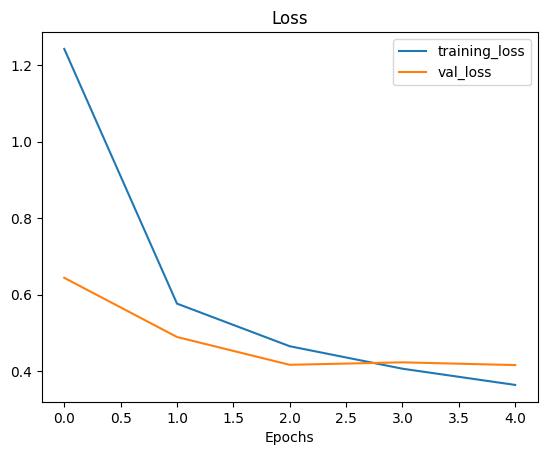

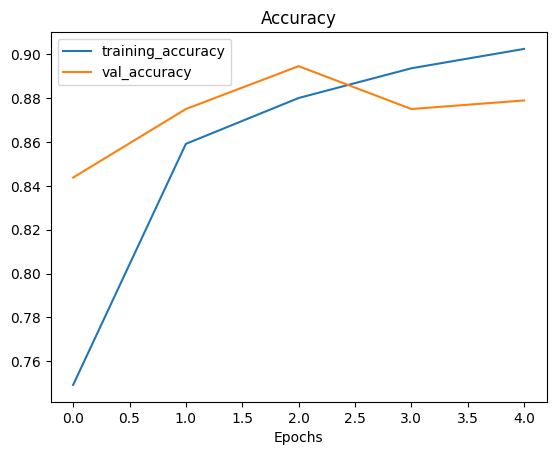

In [ ]:
plot_loss_curves(model_history)

# Fine tuning

In [ ]:
base_model.trainable = True

# allow training of last 5 layers of EfficientNet
for layer in base_model.layers[:-5]:
    layer.trainable = False


# recompile model whenever we make a change
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # lower learning rate for fine tuning because the unfrozen layers have already learned
              metrics=["accuracy"])

In [ ]:
# fine tune for another 3 epochs
fine_tune_epochs = initial_epochs + 3

# refit model (same as without fine-tuning, but has more trainable layers)
model_fine_tune_history = model.fit(train_data,
                                    epochs=fine_tune_epochs,
                                    steps_per_epoch=(len(train_data)),
                                    validation_data=valid_data,
                                    validation_steps=int(0.1 * len(valid_data)),
                                    initial_epoch=model_history.epoch[-1], # start training from previous last epoch
                                    )

Epoch 5/8


2645/2645 [==============================] - 913s 339ms/step - loss: 0.2773 - accuracy: 0.9252 - val_loss: 0.3597 - val_accuracy: 0.9141
Epoch 6/8
2645/2645 [==============================] - 863s 326ms/step - loss: 0.2484 - accuracy: 0.9325 - val_loss: 0.3410 - val_accuracy: 0.9219
Epoch 7/8
2645/2645 [==============================] - 867s 328ms/step - loss: 0.2260 - accuracy: 0.9378 - val_loss: 0.3238 - val_accuracy: 0.9219
Epoch 8/8
2645/2645 [==============================] - 863s 326ms/step - loss: 0.2173 - accuracy: 0.9397 - val_loss: 0.3284 - val_accuracy: 0.9141


In [ ]:
model_tuned_predicted_val_labels = np.argmax(model.predict(valid_data), axis=1)
model_tuned_predicted_test_labels = np.argmax(model.predict(test_data), axis=1)

83/83 [==============================] - 12s 143ms/step


In [ ]:
model_tuned_results = calculate_results(valid_data.labels, model_tuned_predicted_val_labels)
model_tuned_results

{'accuracy': 0.9573333333333334,
 'precision': 0.9659931972789115,
 'recall': 0.9573333333333334,
 'f1': 0.9564192527049669}

In [ ]:
model_test_results = calculate_results(test_data.labels, model_tuned_predicted_test_labels)
model_test_results

{'accuracy': 0.9782857142857143,
 'precision': 0.981859410430839,
 'recall': 0.9782857142857143,
 'f1': 0.9778991378991378}

Save model

In [ ]:
folder_path = "saved_model_h5"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save TF Hub Sentence Encoder model to HDF5 format inside the folder
model.save(os.path.join(folder_path, "bird_model_b2.h5"))

In [ ]:
folder_path = "saved_model_tf"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save TF Hub Sentence Encoder model to TF format inside the folder
model.save(os.path.join(folder_path, "bird_model_b2"))

In [ ]:
saving_path = os.path.join(os.getcwd(), "drive/MyDrive")
# folder_path = "saved_model_tf"
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# Save TF Hub Sentence Encoder model to TF format inside the folder
model.save(os.path.join(saving_path, "bird_model_b2"))

In [ ]:
# Specify the saving path on your Google Drive
saving_path = '/content/drive/MyDrive/saved_models/model'

# Save the TensorFlow model
tf.saved_model.save(model, saving_path)